Saved raw synthetic series to synthetic_market.csv. Shape: (1500, 6)
Feature dataframe shape: (1485, 20)
Train rows: 1188, Test rows: 297


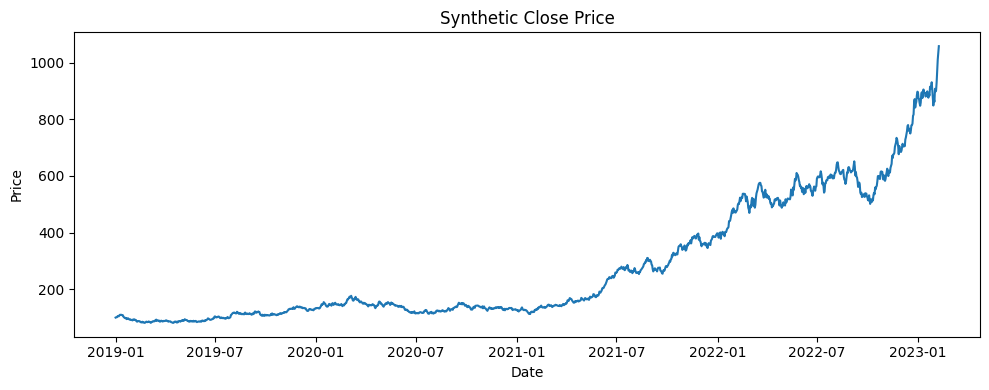

In [1]:
# Cell 1: Generate synthetic share market dataset, preprocess, and split
import os
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Config / seed
np.random.seed(42)
CSV_PATH = "synthetic_market.csv"
TRAIN_CSV = "market_train.csv"
TEST_CSV = "market_test.csv"

def generate_geometric_brownian(start_price=100.0, mu=0.0005, sigma=0.01, days=1500):
    """
    Generate a simple GBM price series (daily) with volume.
    mu: drift per day
    sigma: volatility per day
    """
    dt = 1.0
    prices = [start_price]
    for _ in range(days-1):
        prev = prices[-1]
        shock = np.random.normal(loc=(mu*dt), scale=(sigma*np.sqrt(dt)))
        new = prev * np.exp(shock)
        prices.append(new)
    return np.array(prices)

# Generate dates and series
days = 1500  # ~6 years of trading days (including weekends; synthetic)
start_date = pd.to_datetime("2019-01-01")
dates = pd.date_range(start_date, periods=days, freq="D")  # daily synthetic
close_prices = generate_geometric_brownian(start_price=100.0, mu=0.0006, sigma=0.02, days=days)

# Construct open/high/low from close with small random spreads, and volume
opens = close_prices * (1 + np.random.normal(0, 0.0015, size=days))
highs = np.maximum(opens, close_prices) * (1 + np.abs(np.random.normal(0, 0.005, size=days)))
lows = np.minimum(opens, close_prices) * (1 - np.abs(np.random.normal(0, 0.005, size=days)))
volumes = np.random.randint(100000, 2000000, size=days)

df = pd.DataFrame({
    "date": dates,
    "open": opens,
    "high": highs,
    "low": lows,
    "close": close_prices,
    "volume": volumes
})
df = df.sort_values("date").reset_index(drop=True)

# Save raw CSV
df.to_csv(CSV_PATH, index=False)
print(f"Saved raw synthetic series to {CSV_PATH}. Shape: {df.shape}")

# Preprocessing into supervised features
def make_features(df, lags=[1,2,3,5,7], rolling_windows=[3,7,14]):
    df_feat = df.copy()
    df_feat = df_feat.set_index("date")
    for lag in lags:
        df_feat[f"lag_{lag}"] = df_feat["close"].shift(lag)
    for w in rolling_windows:
        df_feat[f"roll_mean_{w}"] = df_feat["close"].rolling(window=w).mean().shift(1)
        df_feat[f"roll_std_{w}"] = df_feat["close"].rolling(window=w).std().shift(1)
    # Momentum / pct change features
    df_feat["pct_change_1"] = df_feat["close"].pct_change().shift(1)
    df_feat["vol_ma_7"] = df_feat["volume"].rolling(window=7).mean().shift(1)
    # target: next-day close
    df_feat["target_close"] = df_feat["close"].shift(-1)
    df_feat = df_feat.dropna().reset_index()
    return df_feat

df_feat = make_features(df)
print("Feature dataframe shape:", df_feat.shape)
df_feat.head()
# Save processed dataset (optional)
df_feat.to_csv("synthetic_market_features.csv", index=False)

# Time-based train/test split (last 20% as test)
split_index = int(len(df_feat) * 0.8)
train_df = df_feat.iloc[:split_index].reset_index(drop=True)
test_df = df_feat.iloc[split_index:].reset_index(drop=True)

train_df.to_csv(TRAIN_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)
print(f"Train rows: {len(train_df)}, Test rows: {len(test_df)}")

# Quick plot of the close prices
plt.figure(figsize=(10,4))
plt.plot(df['date'], df['close'], label="Close")
plt.title("Synthetic Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


In [2]:
# Cell 2: Train a RandomForestRegressor model and save model + artifacts
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Paths to save
MODEL_PATH = "rf_close_model.pkl"
SCALER_PATH = "scaler.pkl"
ARTIFACT_PATH = "model_artifacts.pkl"  # will store feature list and last known data for forecasting

# Load processed train/test
train_df = pd.read_csv("market_train.csv")
test_df = pd.read_csv("market_test.csv")

# Define features
feature_cols = [c for c in train_df.columns if c not in ["date", "target_close"]]

print("Features used:", feature_cols)

# Scale numeric features (volume might be large)
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
y_train = train_df["target_close"].values
X_test = scaler.transform(test_df[feature_cols])
y_test = test_df["target_close"].values

# Train model
model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
print(f"Test MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Save artifacts
joblib.dump(model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
# Save feature list and full original df (to know last observed window for iterative forecast)
artifacts = {
    "feature_columns": feature_cols,
    "full_raw_csv": "synthetic_market.csv",  # file we generated earlier
    "processed_features_csv": "synthetic_market_features.csv"
}
joblib.dump(artifacts, ARTIFACT_PATH)

print(f"Saved model to {MODEL_PATH}, scaler to {SCALER_PATH}, artifacts to {ARTIFACT_PATH}")


Features used: ['open', 'high', 'low', 'close', 'volume', 'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'roll_mean_3', 'roll_std_3', 'roll_mean_7', 'roll_std_7', 'roll_mean_14', 'roll_std_14', 'pct_change_1', 'vol_ma_7']


TypeError: got an unexpected keyword argument 'squared'

In [3]:
# ==========================
# Train RandomForest and Evaluate
# ==========================
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Paths
MODEL_PATH = "rf_close_model.pkl"
SCALER_PATH = "scaler.pkl"
ARTIFACT_PATH = "model_artifacts.pkl"

# Load processed train/test
train_df = pd.read_csv("market_train.csv")
test_df = pd.read_csv("market_test.csv")

# Define features
feature_cols = [c for c in train_df.columns if c not in ["date", "target_close"]]
print("Features used:", feature_cols)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
y_train = train_df["target_close"].values
X_test = scaler.transform(test_df[feature_cols])
y_test = test_df["target_close"].values

# Train model
model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)
print(f"Test MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# ==========================
# Plot Predictions vs Actuals
# ==========================
plt.figure(figsize=(12,5))
plt.plot(test_df["date"], y_test, label="Actual Close", color="blue")
plt.plot(test_df["date"], preds, label="Predicted Close", color="red", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("RandomForest Regressor Predictions vs Actuals")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ==========================
# Save model and artifacts
# ==========================
joblib.dump(model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
artifacts = {
    "feature_columns": feature_cols,
    "full_raw_csv": "synthetic_market.csv",  
    "processed_features_csv": "synthetic_market_features.csv"
}
joblib.dump(artifacts, ARTIFACT_PATH)

print(f"✅ Saved model to {MODEL_PATH}, scaler to {SCALER_PATH}, artifacts to {ARTIFACT_PATH}")


Features used: ['open', 'high', 'low', 'close', 'volume', 'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'roll_mean_3', 'roll_std_3', 'roll_mean_7', 'roll_std_7', 'roll_mean_14', 'roll_std_14', 'pct_change_1', 'vol_ma_7']


TypeError: got an unexpected keyword argument 'squared'

In [ ]:
# updated

D:\pennylane_setup\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test MAE: 83.97, RMSE: 143.59, R²: -0.2725


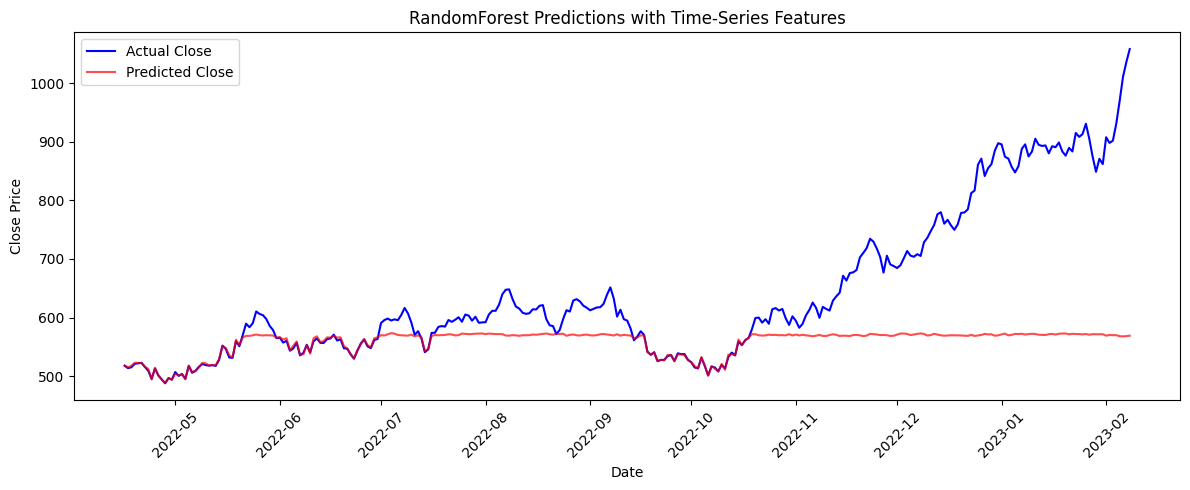

✅ Model, scaler, and artifacts saved!


In [ ]:
# ==========================
# 1. Load dataset
# ==========================
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Load synthetic market data
df = pd.read_csv("synthetic_market.csv", parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

# ==========================
# 2. Feature Engineering
# ==========================
def create_time_series_features(df, target="close"):
    df_feat = df.copy()
    # Lags
    for lag in range(1, 4):
        df_feat[f"lag_{lag}"] = df_feat[target].shift(lag)
    # Rolling statistics
    df_feat["roll_mean_3"] = df_feat[target].shift(1).rolling(window=3).mean()
    df_feat["roll_mean_7"] = df_feat[target].shift(1).rolling(window=7).mean()
    df_feat["roll_std_3"] = df_feat[target].shift(1).rolling(window=3).std()
    df_feat["roll_std_7"] = df_feat[target].shift(1).rolling(window=7).std()
    # Percent change
    df_feat["pct_change_1"] = df_feat[target].pct_change(1)
    df_feat["pct_change_3"] = df_feat[target].pct_change(3)
    # Volume rolling mean
    df_feat["vol_ma_3"] = df_feat["volume"].shift(1).rolling(3).mean()
    df_feat["vol_ma_7"] = df_feat["volume"].shift(1).rolling(7).mean()
    
    # Drop rows with NaN (first few rows due to lag/rolling)
    df_feat = df_feat.dropna().reset_index(drop=True)
    return df_feat

df_feat = create_time_series_features(df)

# Define features and target
target_col = "close"
feature_cols = [c for c in df_feat.columns if c not in ["date", target_col]]

X = df_feat[feature_cols]
y = df_feat[target_col]

# ==========================
# 3. Train/Test Split
# ==========================
split_idx = int(len(df_feat)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================
# 4. Train RandomForest
# ==========================
model = RandomForestRegressor(n_estimators=500, max_depth=15, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
preds = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)

print(f"Test MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# ==========================
# 5. Plot Predictions vs Actual
# ==========================
plt.figure(figsize=(12,5))
plt.plot(df_feat["date"][split_idx:], y_test, label="Actual Close", color="blue")
plt.plot(df_feat["date"][split_idx:], preds, label="Predicted Close", color="red", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("RandomForest Predictions with Time-Series Features")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ==========================
# 6. Save Model & Artifacts
# ==========================
joblib.dump(model, "rf_close_model_ts.pkl")
joblib.dump(scaler, "scaler_ts.pkl")
artifacts = {
    "feature_columns": feature_cols,
    "full_raw_csv": "synthetic_market.csv"
}
joblib.dump(artifacts, "model_artifacts_ts.pkl")

print("✅ Model, scaler, and artifacts saved!")


# LSTM

D:\pennylane_setup\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0100 - val_loss: 0.0025
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.5861e-04 - val_loss: 8.9889e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.8129e-04 - val_loss: 0.0012
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.7760e-04 - val_loss: 0.0011
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.1394e-04 - val_loss: 0.0017
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.5369e-04 - val_loss: 0.0015
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.7394e-04 - val_loss: 0.0024
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.5688e-04 - val_loss: 0.0013
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.8682e-04 - val_loss: 0.0022
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.8177e-04 - val_loss: 0.0013
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.0936e-04 - val_loss: 0.0026
Epoch 12/50
38/38 

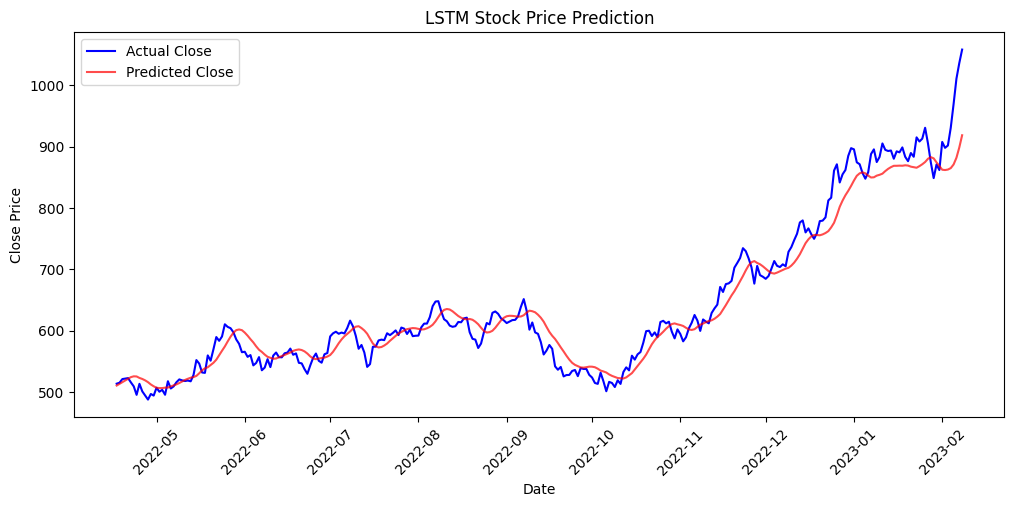

LSTM Test MAE: 20.82, RMSE: 28.49, R²: 0.9499
✅ LSTM model and scaler saved!


In [ ]:
# ==========================
# 1. Load Data
# ==========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

df = pd.read_csv("synthetic_market.csv", parse_dates=["date"])


df = df.sort_values("date").reset_index(drop=True)

# Use close price (you can add volume later)
data = df[["close"]].values

# ==========================
# 2. Scale Data
# ==========================
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# ==========================
# 3. Create Sequences
# ==========================
def create_sequences(data, n_steps=10):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_steps = 10
X, y = create_sequences(data_scaled, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, timesteps, features)

# Train/test split
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ==========================
# 4. Build LSTM Model
# ==========================
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")
model.summary()

# ==========================
# 5. Train Model
# ==========================
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)

# ==========================
# 6. Predictions & Evaluation
# ==========================
y_pred = model.predict(X_test)
# Inverse scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(12,5))
plt.plot(df["date"][split_idx+n_steps:], y_test_inv, label="Actual Close", color="blue")
plt.plot(df["date"][split_idx+n_steps:], y_pred_inv, label="Predicted Close", color="red", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("LSTM Stock Price Prediction")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Compute RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"LSTM Test MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# ==========================
# 7. Save Model & Scaler
# ==========================
model.save("lstm_close_model.h5")
import joblib
joblib.dump(scaler, "lstm_scaler.pkl")
print("✅ LSTM model and scaler saved!")


        date  pred_close
0 2023-02-09  936.662354
1 2023-02-10  941.907532
2 2023-02-11  940.267639
3 2023-02-12  934.803101
4 2023-02-13  927.832458


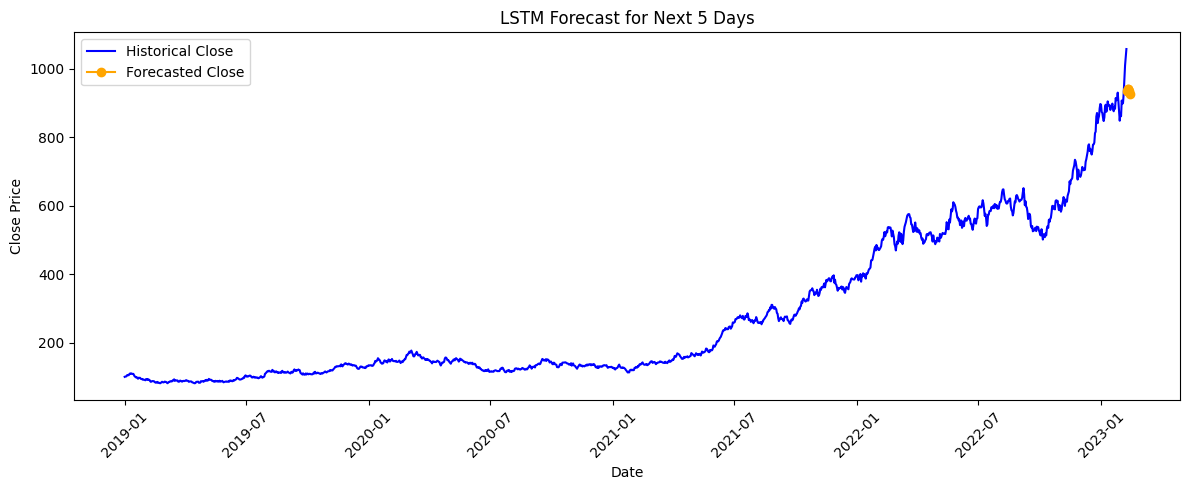

In [ ]:
# ==========================
# LSTM Forecast Next n Days
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib

# --------------------------
# Load data, model, scaler
# --------------------------
df = pd.read_csv("synthetic_market.csv", parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

lstm_model = load_model("lstm_close_model.h5", compile=False)  # fix for H5 load issue
scaler = joblib.load("lstm_scaler.pkl")

# --------------------------
# Forecast function
# --------------------------
def forecast_next_days_lstm(df, n_days=5, n_steps=10):
    """
    Iteratively forecast next n_days of stock close prices using LSTM.
    
    df: DataFrame with 'close' and 'date' columns
    n_days: number of future days to forecast
    n_steps: number of past days LSTM uses for prediction
    """
    df_sorted = df.sort_values("date").reset_index(drop=True)
    close_prices = df_sorted["close"].values
    forecasted = []
    
    last_sequence = close_prices[-n_steps:]  # initial input for LSTM
    
    for day in range(1, n_days+1):
        # Scale last sequence
        seq_scaled = scaler.transform(last_sequence.reshape(-1,1)).reshape(1, n_steps, 1)
        
        # Predict next day
        pred_scaled = lstm_model.predict(seq_scaled, verbose=0)
        pred_close = scaler.inverse_transform(pred_scaled.reshape(-1,1))[0,0]
        
        # Append prediction
        last_date = df_sorted["date"].max()
        forecast_date = last_date + pd.Timedelta(days=day)
        forecasted.append({"date": forecast_date, "pred_close": pred_close})
        
        # Update sequence
        last_sequence = np.append(last_sequence[1:], pred_close)
    
    return pd.DataFrame(forecasted)

# --------------------------
# Run forecast & plot
# --------------------------
forecast_df = forecast_next_days_lstm(df, n_days=5, n_steps=10)
print(forecast_df)

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["close"], label="Historical Close", color="blue")
plt.plot(forecast_df["date"], forecast_df["pred_close"], label="Forecasted Close", color="orange", marker='o')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("LSTM Forecast for Next 5 Days")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Cell 3: Load model and provide query functions
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity  # not used, but kept if you expand
from datetime import timedelta

MODEL_PATH = "rf_close_model.pkl"
SCALER_PATH = "scaler.pkl"
ARTIFACT_PATH = "model_artifacts.pkl"

# Load
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
artifacts = joblib.load(ARTIFACT_PATH)
feature_cols = artifacts["feature_columns"]

# Load the full raw and processed datasets
full_raw = pd.read_csv(artifacts["full_raw_csv"], parse_dates=["date"])
processed = pd.read_csv(artifacts["processed_features_csv"], parse_dates=["date"])

# Helper: create feature row given a historic df and last_date; returns df row for model
def build_feature_row(history_df, current_date):
    """
    history_df: full raw df with date, open, high, low, close, volume
    current_date: pd.Timestamp for which we will create features based on past data
    This function constructs the features matching 'feature_cols' for a row whose 'close' is known for current_date.
    """
    # we expect history_df to include current_date
    dfh = history_df.set_index("date").sort_index()
    if current_date not in dfh.index:
        raise ValueError("current_date must be present in history_df index for feature building.")
    # create a small helper series
    row = {}
    # lags: lag_1 = close at day-1 etc
    for col in feature_cols:
        if col.startswith("lag_"):
            lag = int(col.split("_")[1])
            lag_date = current_date - pd.Timedelta(days=lag)
            row[col] = dfh.at[lag_date, "close"] if lag_date in dfh.index else np.nan
        elif col.startswith("roll_mean_"):
            w = int(col.split("_")[-1])
            window_end = current_date - pd.Timedelta(days=1)
            window_start = window_end - pd.Timedelta(days=w-1)
            window = dfh.loc[window_start:window_end]["close"]
            row[col] = window.mean() if not window.empty else np.nan
        elif col.startswith("roll_std_"):
            w = int(col.split("_")[-1])
            window_end = current_date - pd.Timedelta(days=1)
            window_start = window_end - pd.Timedelta(days=w-1)
            window = dfh.loc[window_start:window_end]["close"]
            row[col] = window.std() if not window.empty else np.nan
        elif col == "pct_change_1":
            prev = current_date - pd.Timedelta(days=1)
            if prev in dfh.index and (dfh.at[prev, "close"] != 0):
                row[col] = (dfh.at[prev, "close"] - dfh.at[prev - pd.Timedelta(days=1), "close"]) / dfh.at[prev - pd.Timedelta(days=1), "close"] if (prev - pd.Timedelta(days=1)) in dfh.index else 0.0
            else:
                row[col] = 0.0
        elif col == "vol_ma_7":
            window_end = current_date - pd.Timedelta(days=1)
            window_start = window_end - pd.Timedelta(days=6)
            window = dfh.loc[window_start:window_end]["volume"]
            row[col] = window.mean() if not window.empty else dfh.at[window_end, "volume"] if window_end in dfh.index else np.nan
        else:
            # fallback: try to pull that column if exists in raw
            if col in dfh.columns:
                row[col] = dfh.at[current_date, col]
            else:
                row[col] = np.nan
    # convert to df
    feat_df = pd.DataFrame([row])
    return feat_df

# Iterative forecasting function: forecast next n days using last available day in full_raw
# ==========================
# Updated Iterative Forecast Function
# ==========================

def forecast_next_days(n=5):
    """
    Iteratively forecast next n days of close price.
    Uses the last row in full_raw as the most recent observed day.
    """
    hist = full_raw.copy().set_index("date").sort_index()
    last_date = hist.index.max()
    results = []
    history = hist.copy()

    for step in range(1, n + 1):
        target_date = last_date + pd.Timedelta(days=step)
        current_date_for_features = target_date - pd.Timedelta(days=1)

        # If current_date_for_features not in history, create synthetic row
        if current_date_for_features not in history.index:
            last_row = history.iloc[-1]
            synth = last_row.copy()
            synth.name = current_date_for_features
            # ✅ Use pd.concat instead of append
            history = pd.concat([history, pd.DataFrame([synth.values], index=[current_date_for_features], columns=history.columns)])

        # Build features referencing history
        feat_row = build_feature_row(history.reset_index().rename(columns={"index": "date"}), current_date_for_features)

        # Scale features
        X = scaler.transform(feat_row[feature_cols].ffill().bfill())
        pred_close = model.predict(X)[0]

        results.append({"date": target_date.strftime("%Y-%m-%d"), "pred_close": float(pred_close)})

        # Append predicted day to history for next iteration
        avg_vol = int(history["volume"].tail(7).mean())
        new_row = {
            "open": pred_close,
            "high": pred_close * 1.002,
            "low": pred_close * 0.998,
            "close": pred_close,
            "volume": avg_vol
        }
        # ✅ Use pd.concat instead of append
        history = pd.concat([history, pd.DataFrame([new_row], index=[target_date])])

    return pd.DataFrame(results)


# ==========================
# Updated Predict Close for Specific Date
# ==========================

def predict_date(date_str):
    """
    Predict close for a specific future date.
    If the date is beyond the last observed, extend history iteratively.
    """
    date = pd.to_datetime(date_str)
    history = full_raw.copy().set_index("date").sort_index()
    last_date = history.index.max()
    current_date = date - pd.Timedelta(days=1)

    # If current_date is beyond last observed, extend history iteratively
    if current_date > last_date:
        steps = (current_date - last_date).days
        _ = forecast_next_days(steps)  # this internally extends full_raw for next steps

        # Rebuild local history to include synthetic rows
        history = full_raw.copy().set_index("date").sort_index()
        last_date = history.index.max()
        while current_date > last_date:
            last_row = history.iloc[-1]
            synth = last_row.copy()
            synth.name = last_date + pd.Timedelta(days=1)
            history = pd.concat([history, pd.DataFrame([synth.values], index=[synth.name], columns=history.columns)])
            last_date = history.index.max()

    # Now build features safely
    feat_row = build_feature_row(history.reset_index().rename(columns={"index": "date"}), current_date)
    X = scaler.transform(feat_row[feature_cols].ffill().bfill())
    pred_close = model.predict(X)[0]

    return {"date": date_str, "pred_close": float(pred_close)}



# ==========================
# Demo Usage
# ==========================
print("Forecast next 5 days (iterative):")
print(forecast_next_days(5))

print("\nPredict close on a date (example):")
print(predict_date((full_raw['date'].max() + pd.Timedelta(days=3)).strftime("%Y-%m-%d")))


Forecast next 5 days (iterative):
         date  pred_close
0  2023-02-09  562.926244
1  2023-02-10  558.595091
2  2023-02-11  556.811892
3  2023-02-12  557.085054
4  2023-02-13  558.907910

Predict close on a date (example):
{'date': '2023-02-11', 'pred_close': 562.9672767088671}
